Reference link: https://www.pyimagesearch.com/2014/12/01/complete-guide-building-image-search-engine-python-opencv/

# IMAGE SEARCH

In [ ]:
import os
import time
import imutils
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from IPython.display import clear_output
from imutils import paths

In [ ]:
def download_from_gdrive(file_id, file_name):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget \
    --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
    'https://docs.google.com/uc?export=download&id=$file_id' -O- | \
    sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$file_id" \
    -O $file_name && rm -rf /tmp/cookies.txt
    clear_output(wait=True)

    print("{} downloaded!".format(file_name))

In [ ]:
# download dogs.zip file from google drive
download_from_gdrive("1sM5Qm_ouTcvmLBf-GM2AJgwPAoGvXhhZ", "dogs.zip")

dogs.zip downloaded!


In [ ]:
# unzig the dogs file
!unzip -qq dogs.zip

In [ ]:
# download the feature descriptor
download_from_gdrive("1Qrz3dKCVJpyJlMH6eejeSaOUlp7BnW2u", "features.csv")

features.csv downloaded!


## Feature Extractor

In [ ]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model

    def extract_features(self, image):
        # prepare image to pass through the model
        image = self.prepare_image(image)
        # get the features
        features = self.model(image)
        # convert to numpy and reshape
        features = features.numpy().reshape((-1,)) # reshape to (2048,)
        return features
        
    def prepare_image(self, image):
        # preprocess using model's preprocess_input func
        image = preprocess_input(image)
        # expand the dimension: (224, 224, 3) => (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        return image

## Searcher

In [ ]:
import csv

class Searcher:
    def __init__(self, indexPath):
        # store the index path
        self.indexPath = indexPath

    def search(self, queryFeatures, limit = 10):
        # initialize our dictionary of results
        results = {}

        # open the index file for reading
        with open(self.indexPath) as f:
            # initialize the CSV reader
            reader = csv.reader(f)

            # loop over the rows in the index
            for row in reader:
                # parse out the image ID and features, then compute
                # the chi-squared distance between the features in our index
                # and our query features
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, queryFeatures)

                # now that we have the distance between the two feature
                # vectors, we can update the results dictionary -- the
                # key is the current image ID in the index and the value 
                # is the distance we just computed, representing how similar
                # the image in the index is to our query
                results[row[0]] = d
            
            # close the reader
            f.close()
        
        # sort our results, so that the smaller distances
        # images are at the front of the list
        results = sorted([(v, k) for (k, v) in results.items()])

        # return our results
        return results[1:limit+1]

    def chi2_distance(self, featA, featB, eps = 1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
            for (a, b) in zip(featA, featB)])
        # return the chi-squared distance
        return d

## Load Model

In [ ]:
# load the feature extractor model
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
# create an instance of FeatureExtractor class
fe = FeatureExtractor(model)

In [ ]:
def load_image(imgpath):
    image = cv2.imread(imgpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=200)
    return image

def search_similar_dogs(query_image_path, features_path):
    queryID = query_image_path.split(os.path.sep)[1]
    indexPath = features_path

    # load the query image and describe it
    query = cv2.imread(query_image_path)
    query = cv2.resize(query, (224, 224), interpolation=cv2.INTER_AREA)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    features = fe.extract_features(query)# cd.describe(query)

    # perform the search
    print("Searching for similar dogs...")
    searcher = Searcher(indexPath)
    # start time
    start = time.time()
    # search
    results = searcher.search(features)
    print("Time taken for search: {:.2f} secs\n".format(time.time() - start))

    # resize the query image for displaying
    resized = imutils.resize(query, width=200)
    plt.imshow(resized)
    plt.axis("off")
    plt.title(f"Query Image\n{queryID}", fontsize=18)
    plt.show()

    # create a figure object
    fig = plt.figure(figsize=(10, 6))
    # loop over the results and display the similar images
    for i, result in enumerate(results):
        ax = fig.add_subplot(2, 5, i+1)
        img_paths = list(paths.list_images(os.path.join(f"dogs", result[1])))
        image = load_image(img_paths[0])
        plt.imshow(image)
        plt.axis('off')
        plt.title(result[1])
    plt.tight_layout()
    plt.suptitle("Similar Dogs\n", fontsize=16)
    plt.show()

## Search for Similar Dogs

Searching for similar dogs...
Time taken for search: 170.55 secs



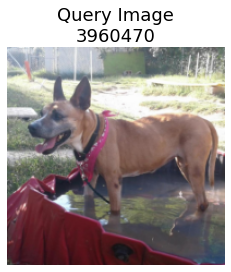

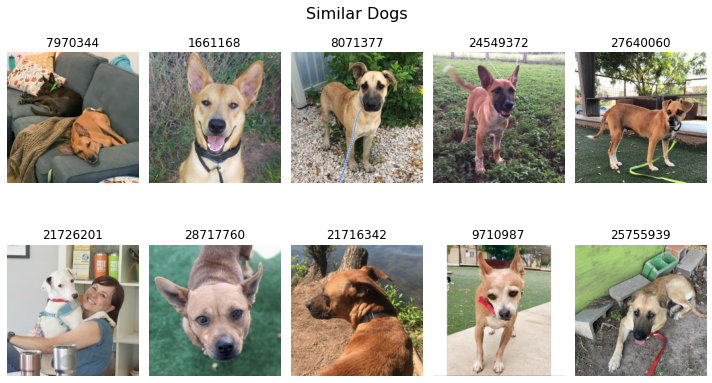

In [ ]:
# get the list of all image paths
image_paths = list(paths.list_images("dogs"))

# query image path
query_path = image_paths[8]
search_similar_dogs(query_path, "features.csv")